
# <span style="color:rgb(213,80,0)">Pitch Shifting and Time Dilation Using a Phase Vocoder in MATLAB</span>

This example shows how to implement a phase vocoder to time stretch and pitch scale an audio signal.

## Introduction

The phase vocoder performs time stretching and pitch scaling by transforming the audio into frequency domain. The following block diagram shows the operations involved in the phase vocoder implementation.


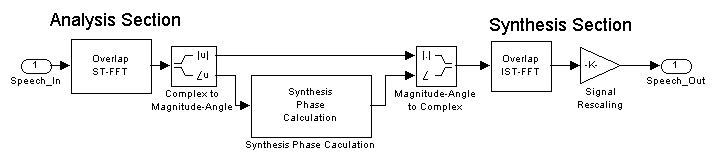


The phase vocoder has an analysis section that performs an overlapped short\-time FFT (ST\-FFT) and a synthesis section that performs an overlapped inverse short\-time FFT (IST\-FFT). To time stretch a signal, the phase vocoder uses a larger hop size for the overlap\-add operation in the synthesis section than the analysis section. Here, the hop size is the number of samples processed at one time. As a result, there are more samples at the output than at the input although the frequency content remains the same. Now, you can pitch scale this signal by playing it back at a higher sample rate, which produces a signal with the original duration but a higher pitch.

## Initialization

To achieve optimal performance, you must create and initialize your System objects before using them in a processing loop. Use these next sections of code to initialize the required variables and load the input speech data. You set an analysis hop size of 64 and a synthesis hop size of 90 because you want to stretch the signal by a factor of 90/64.


Initialize some variables used in configuring the System objects you create below.


In [1]:
WindowLen = 256;
AnalysisLen = 64;
SynthesisLen = 90;
Hopratio = SynthesisLen/AnalysisLen;


Create a System object to read in the input speech signal from an audio file.


In [2]:
reader = dsp.AudioFileReader('SpeechDFT-16-8-mono-5secs.wav', ...
  'SamplesPerFrame',AnalysisLen, ...
  'OutputDataType','double');


Create STFT/ISTFT pair


In [3]:
win = sqrt(hanning(WindowLen,'periodic'));
stft = dsp.STFT(win, WindowLen - AnalysisLen, WindowLen);
istft = dsp.ISTFT(win, WindowLen - SynthesisLen );


Create a System object to play the original speech signal.


In [4]:
Fs = 8000;
player = audioDeviceWriter('SampleRate',Fs, ...
    'SupportVariableSizeInput',true, ...
    'BufferSize',512);



Create a System object to log your data.


In [5]:
logger = dsp.SignalSink;


Initialize the variables used in the processing loop.


In [6]:
unwrapdata = 2*pi*AnalysisLen*(0:WindowLen-1)'/WindowLen;
yangle = zeros(WindowLen,1);
firsttime = true;

## Stream Processing Loop

Now that you have instantiated your System objects, you can create a processing loop that performs time stretching on the input signal. The loop is stopped when you reach the end of the input file, which is detected by the <samp>AudioFileReader</samp> System object.


In [7]:
while ~isDone(reader)
    y = reader();

    player(y); % Play back original audio

    % ST-FFT
    yfft = stft(y);

    % Convert complex FFT data to magnitude and phase.
    ymag       = abs(yfft);
    yprevangle = yangle;
    yangle     = angle(yfft);

    % Synthesis Phase Calculation
    % The synthesis phase is calculated by computing the phase increments
    % between successive frequency transforms, unwrapping them, and scaling
    % them by the ratio between the analysis and synthesis hop sizes.
    yunwrap = (yangle - yprevangle) - unwrapdata;
    yunwrap = yunwrap - round(yunwrap/(2*pi))*2*pi;
    yunwrap = (yunwrap + unwrapdata) * Hopratio;
    if firsttime
        ysangle = yangle;
        firsttime = false;
    else
        ysangle = ysangle + yunwrap;
    end

    % Convert magnitude and phase to complex numbers.
    ys = ymag .* complex(cos(ysangle), sin(ysangle));

    % IST-FFT
    yistfft = istft(ys);

    logger(yistfft) % Log signal
end

## Release

Call  release on the System objects to close any open files and devices.


In [8]:
release(reader)
release(player)

## Play the Time\-Stretched Signals

In [9]:
loggedSpeech = logger.Buffer(200:end)';
player = audioDeviceWriter('SampleRate',Fs, ...
    'SupportVariableSizeInput',true, ...
    'BufferSize',512);
player(loggedSpeech.');

## Play the Pitch\-Scaled Signals

The pitch\-scaled signal is the time\-stretched signal played at a higher sampling rate which produces a signal with a higher pitch.


In [10]:
Fs_new = Fs*(SynthesisLen/AnalysisLen);
player = audioDeviceWriter('SampleRate',Fs_new, ...
    'SupportVariableSizeInput',true, ...
    'BufferSize',1024);
player(loggedSpeech.');

## Time Dilation with <samp>audioTimeScaler</samp>

You can easily apply time dilation with [audioTimeScaler](docid:audio_ref#mw_9e215ef9-f35b-4642-8873-e54e9e1ea4e5). <samp>audioTimeScaler</samp> implements an analysis\-synthesis phase vocoder for time scaling.


Instantiate an <samp>audioTimeScaler</samp> with the desired speedup factor, window, and analysis hop length:


In [11]:
ats = audioTimeScaler(AnalysisLen/SynthesisLen,'Window',win,'OverlapLength',WindowLen-AnalysisLen);


Create a System object to play the time\-stretched speech signal.


In [12]:
player = audioDeviceWriter('SampleRate',Fs, ...
    'SupportVariableSizeInput',true, ...
    'BufferSize',512);


Create a processing loop that performs time stretching on the input signal.


In [13]:
while ~isDone(reader)

    x = reader();

    % Time-scale the signal
    y = ats(x);

    % Play the time-scaled signal
    player(y);
end

release(reader)
release(player)

## Summary

This example shows the implementation of a phase vocoder to perform time stretching and pitch scaling of a speech signal. You can hear these time\-stretched and pitch\-scaled signals when you run the example.

## References

A. D. Gotzen, N. Bernardini and D. Arfib, "Traditional Implementations of a Phase\-Vocoder: The Tricks of the Trade," Proceedings of the COST G\-6 Conference on Digital Audio Effects (DAFX\-00), Verona, Italy, December 7\-9, 2000.


*Copyright 1995\-2019 The MathWorks, Inc.*

